In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.fftpack import fft, ifft
from scipy.signal import wiener, resample
from skimage.restoration import denoise_wavelet

import os
import wfdb # MIT-BIH files
import pywt
import h5py

ARRYTHMIA_PATH = "data/arrythmia_rates/"
NORMAL_PATH = "data/normal_rates/"


anomalies = ['L','R','V','/','A','f','F','j','a','E','J','e','S']

normal = ['N'] 


**N** - NORMAL, Normal beat <br>
**L** - LBBB, Left bundle branch block beat <br>
**R** - RBBB, Right bundle branch block beat <br>
**a** - ABERR, Aberrated atrial premature beat <br>
**V** - PVC, Premature ventricular contraction <br>
**F** - FUSION, Fusion of ventricular and normal beat <br>
**J** - NPC, Nodal (junctional) premature beat <br>
**A** - APC, Atrial premature contraction <br>
**S** - SVPB, Premature or ectopic supraventricular beat <br>
**E** - VESC, Ventricular escape beat <br>
**j** - NESC, Nodal (junctional) escape beat <br>
**/** - PACE, Paced beat <br>
**f** - PFUS, Fusion of paced and normal beat <br>
**e** - AESC, Atrial escape beat <br>

In [122]:
c = 0

for file in os.listdir(NORMAL_PATH):
    #print(file)
    if file.endswith("atr"):
        c += 1
        temp = wfdb.rdann(NORMAL_PATH + file.split(".")[0], "atr", sampto=300)
    if file.endswith("dat"):
        record = wfdb.rdrecord(NORMAL_PATH + file.split(".")[0], sampto=300)

print(c)

18


I only need **MLII (Modified Lead II)** signals, because they are the most essential here.

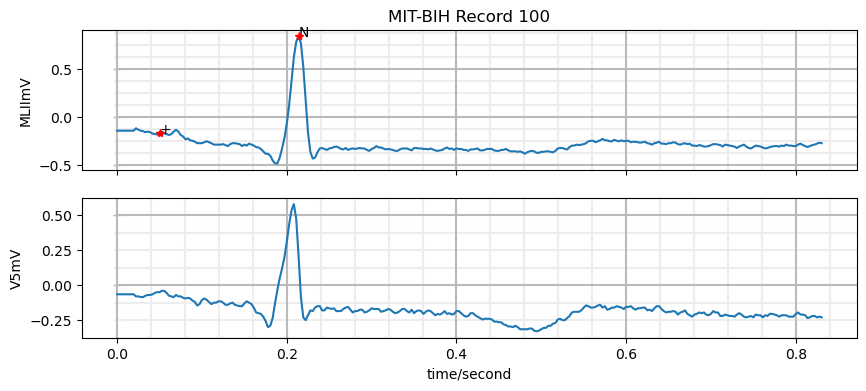

In [5]:
wfdb.plot_wfdb(record=record, annotation=temp, plot_sym=True,
                   time_units='seconds', title='MIT-BIH Record 100',
                   figsize=(10,4), ecg_grids='all')

In [6]:
record.p_signal[18]

array([-0.17, -0.05])

In [7]:
temp.sample

array([18, 77], dtype=int64)

In [4]:
def plot_signal(ax, signal: np.array, annot_sample: int, annot_symbol: str, fs=360):
    #fig = plt.figure(figsize=(10, 5))
    #ax = fig.add_subplot(111)
    ax.plot(np.arange(signal.shape[0]) / fs, signal, c="springgreen")
    ax.plot(annot_sample / fs, signal[annot_sample], 'ro', alpha=0.5)
    ax.annotate(annot_symbol, [annot_sample / fs + 0.02, signal[annot_sample]], c="white")
    ax.set_ylabel("Signal Strength [mV]")
    ax.set_xlabel("Seconds [s]")

    ax.set_facecolor((0.1, 0.1, 0.1))

    ax.set_title("MLII Signal Part")
    ax.grid()
    
    return ax


def plot_signal_data(ax, x: np.array, y: np.array, plot_kws: dict = {}, fs: int = 360):
    if "c" not in plot_kws.keys():
        plot_kws["c"] = "green"
    
    ax.plot(x, y, **plot_kws)
    ax.set_ylabel("Signal Strength [mV]")
    ax.set_xlabel("Seconds [s]")

    ax.set_facecolor((0.1, 0.1, 0.1))

    ax.set_title("MLII Signal Part")
    ax.grid()
    
    return ax

In [3]:
def load_full_ecg(path, id):
    record = wfdb.rdrecord(path + id)
    ann = wfdb.rdann(path + id, "atr")

    signal = record.p_signal[:, 0] # MLII
    ann_sample = ann.sample # annotation locations
    ann_symbol = ann.symbol # annotation symbols
    
    return signal, ann_sample, ann_symbol

In [27]:
s,a,an = load_full_ecg(ARRYTHMIA_PATH, "119")

In [29]:
pd.Series(np.array(an)).value_counts()

N    1543
V     444
+     103
~       4
Name: count, dtype: int64

In [7]:
seconds = 1.2 # window around annotation
labels = []
signals = []
symbols = []
for patient in set([file[:3] for file in os.listdir(ARRYTHMIA_PATH)]): # unique patient ids
    ecg_signal, ecg_annotation, annotation_symbol = load_full_ecg(ARRYTHMIA_PATH, patient)
    
    for smpl, symb in zip(ecg_annotation, annotation_symbol):
        if symb in anomalies: # looking only for abnormal annotations here
            temp_signal = ecg_signal[smpl-int(seconds*360):smpl+int(seconds*360)]

            if len(temp_signal) > 0:
                signals.append(temp_signal)
                labels.append(1) # marking anomalied as 1
                symbols.append(symb)

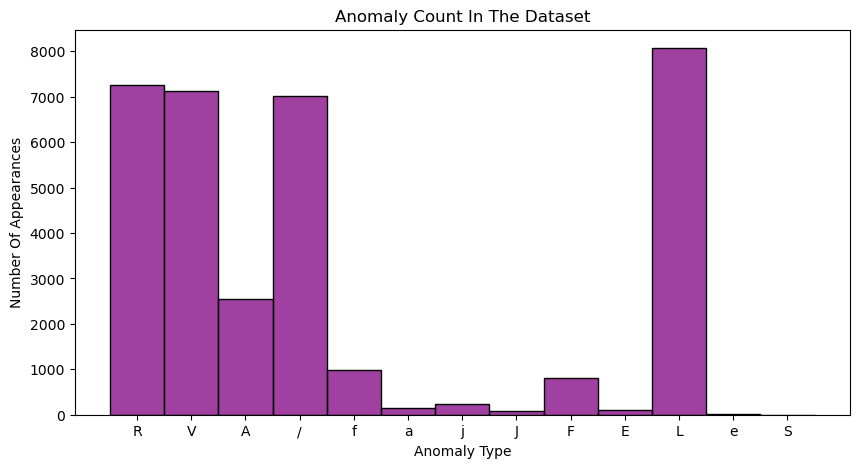

In [138]:
plt.figure(figsize=(10,5))
sns.histplot(np.array(symbols), color="purple")
plt.title("Anomaly Count In The Dataset")
plt.xlabel("Anomaly Type")
plt.ylabel("Number Of Appearances")
plt.show()

# Plotting random anomalies

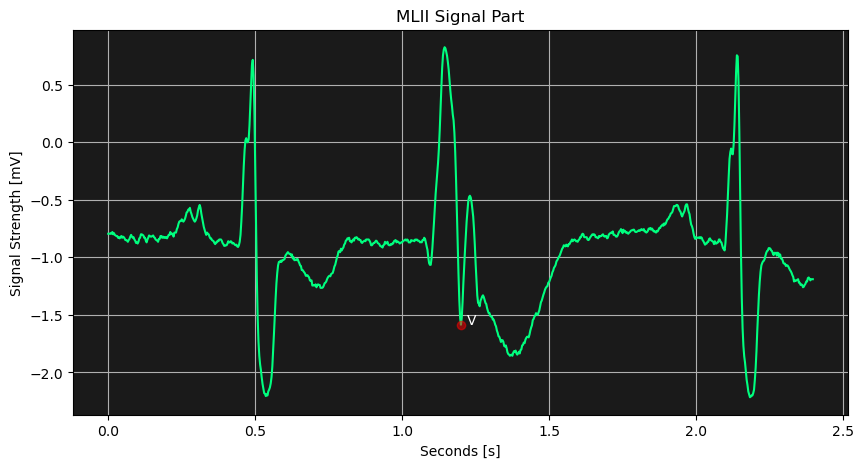

In [188]:
idx = symbols.index("V")
fig, ax = plt.subplots(figsize=(10,5))
a = plot_signal(ax, signals[idx], int(seconds*360), symbols[idx])

fig.savefig("graphs/random_anomaly1.png")

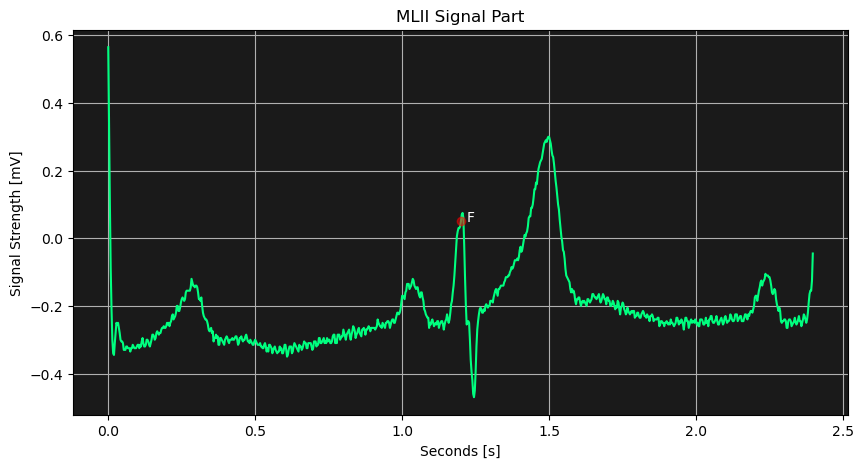

In [190]:
idx = symbols.index("F")
fig, ax = plt.subplots(figsize=(10,5))
a = plot_signal(ax, signals[idx], int(seconds*360), symbols[idx])

fig.savefig("graphs/random_anomaly2.png")

In [50]:
for file in os.listdir(NORMAL_PATH)[:3]:
    print(file)
    if file.endswith("atr"):
        temp = wfdb.rdann(NORMAL_PATH + file.split(".")[0], "atr")
    if file.endswith("dat"):
        record = wfdb.rdrecord(NORMAL_PATH + file.split(".")[0])

16265.atr
16265.dat
16265.hea


In [9]:
labels_tt = []
signals_tt = []
symbols_tt = []
for patient in set([file[:5] for file in os.listdir(NORMAL_PATH)]): # unique patient ids
    if not patient[0].isdigit():
        continue
    ecg_signal, ecg_annotation, annotation_symbol = load_full_ecg(NORMAL_PATH, patient)

    print(patient, len(annotation_symbol))
    
    for smpl, symb in zip(ecg_annotation, annotation_symbol):
        temp_signal = ecg_signal[smpl-int(seconds*128):smpl+int(seconds*128)]
            
        signals_tt.append(temp_signal)
        labels_tt.append(0)
        symbols_tt.append(symb)

16273 90097
16420 102436
19830 111263
16786 101739
17052 88002
16265 100955
19140 96992
19090 81953
19088 117880
16483 104561
16539 108674
18184 102672
19093 83670
17453 101173
16773 112897
16795 87678
18177 117004
16272 97146


In [40]:
print(len(ecg_signal)/128/3600)

25.0


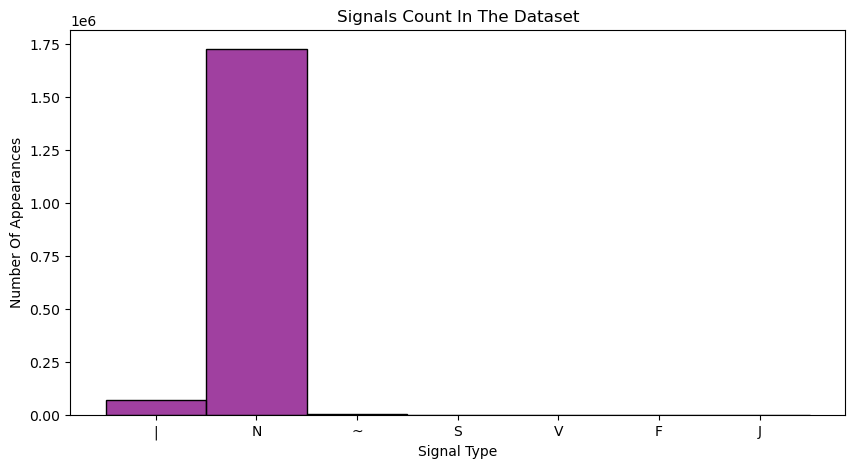

In [142]:
plt.figure(figsize=(10,5))
sns.histplot(np.array(symbols_tt), color="purple")
plt.title("Signals Count In The Dataset")
plt.xlabel("Signal Type")
plt.ylabel("Number Of Appearances")
plt.show()

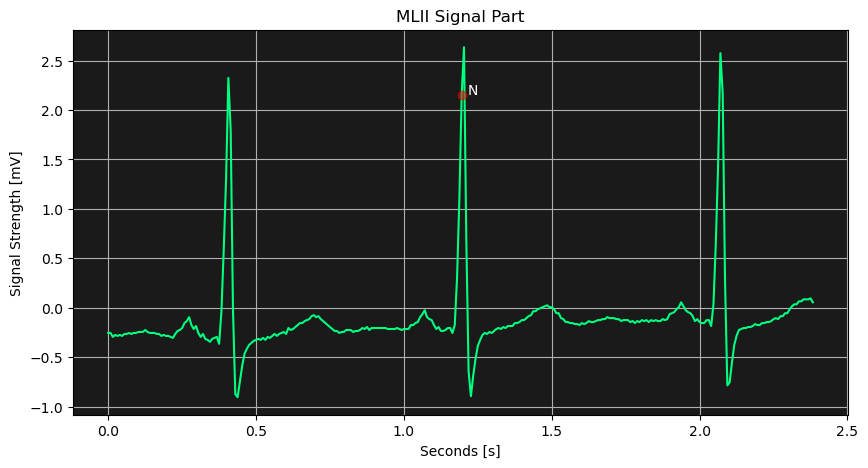

In [192]:
fig, ax = plt.subplots(figsize=(10,5))
plot_signal(ax, signals_tt[700000], int(seconds*128), symbols_tt[700000], fs=128)

plt.show()
fig.savefig("graphs/random_normal1.png")

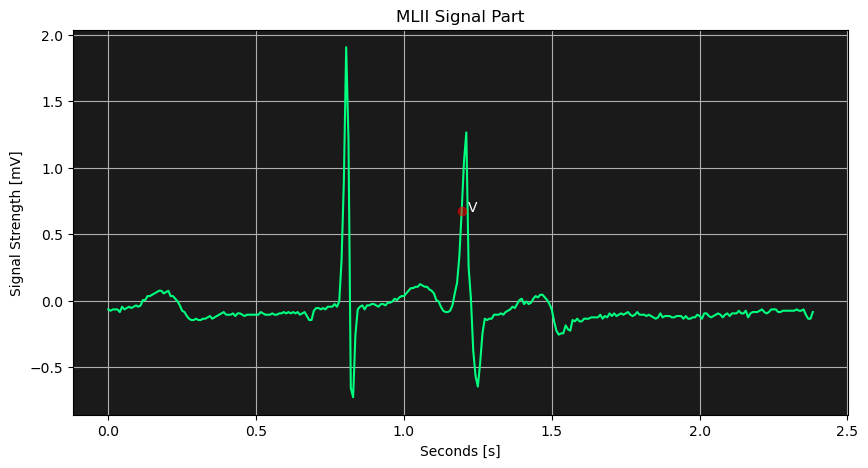

In [32]:
idx = symbols_tt.index("V")
fig, ax = plt.subplots(figsize=(10,5))
plot_signal(ax, signals_tt[idx], int(seconds*128), symbols_tt[idx], fs=128)

plt.show()

# FFT + Wiener

In [22]:
def fft_threshold(signal: np.array, fs: int, threshold: int = 40, time_frame: float = 2*1.2):
    t = np.linspace(0, time_frame, int(fs*time_frame))
    if fs == 360:
        t = t[:-1]
    
    fft_signal = fft(signal)
    frequencies = np.fft.fftfreq(len(fft_signal), 1/fs)

    fft_signal_filtered = fft_signal.copy()
    fft_signal_filtered[(frequencies > 40)] = 0

    filtered_signal = ifft(fft_signal_filtered)

    return fft_signal, fft_signal_filtered, frequencies, filtered_signal.real



def fft_wiener_denoise(signal: np.array, fs: int, time_frame: float = 2*1.2, threshold=40, wiener_size=9):
    _, _, _, filtered_signal = fft_threshold(signal, fs, threshold, time_frame) # fft frequency threshold

    return wiener(filtered_signal, mysize=wiener_size)

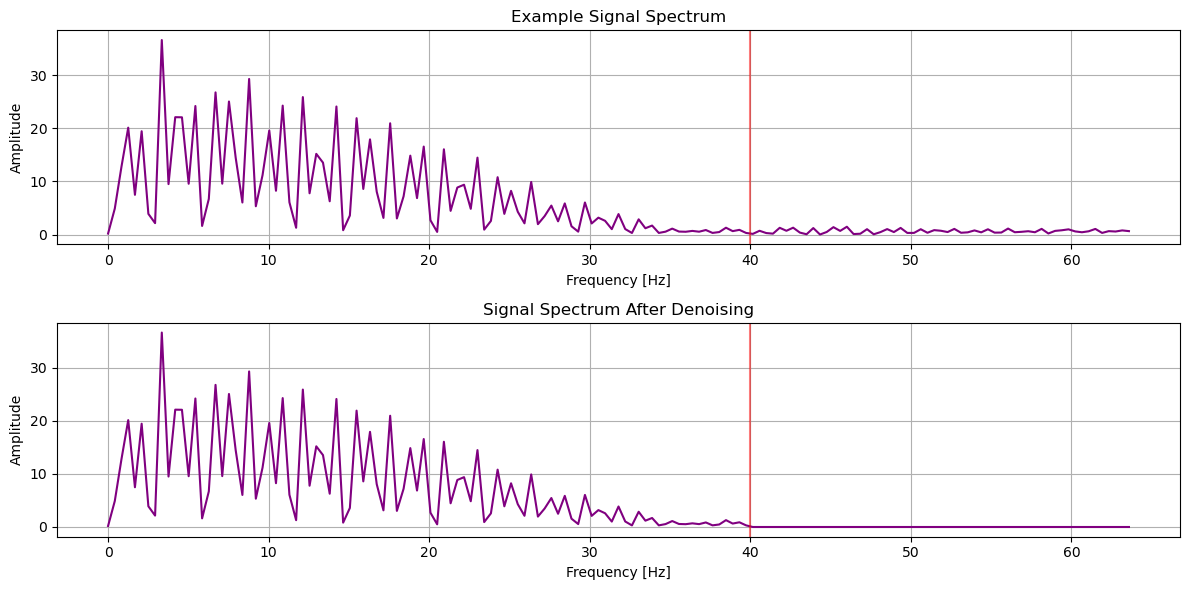

In [10]:
time_frame = 2 * 1.2

t_anomaly = np.linspace(0, time_frame, int(360*time_frame))
t_normal = np.linspace(0, time_frame, int(128*time_frame))[:-1]

fft_signal, fft_signal_filtered, frequencies, _ = fft_threshold(signal=signals_tt[50000], fs=128)


plt.figure(figsize=(12, 6))
plt.subplot(211)
plt.plot(frequencies[:len(frequencies)//2], np.abs(fft_signal)[:len(frequencies)//2], c="purple")
plt.axvline(x=40, c="red", alpha=0.5)
plt.title('Example Signal Spectrum')
plt.xlabel('Frequency [Hz]')
plt.ylabel('Amplitude')
plt.grid()

plt.subplot(2, 1, 2)
plt.plot(frequencies[:len(frequencies)//2], np.abs(fft_signal_filtered)[:len(frequencies)//2], c="purple")
plt.axvline(x=40, c="red", alpha=0.5)
plt.title('Signal Spectrum After Denoising')
plt.xlabel('Frequency [Hz]')
plt.ylabel('Amplitude')
plt.tight_layout()
plt.grid()

#plt.savefig("graphs/spectrum_thresholding.png")
plt.show()

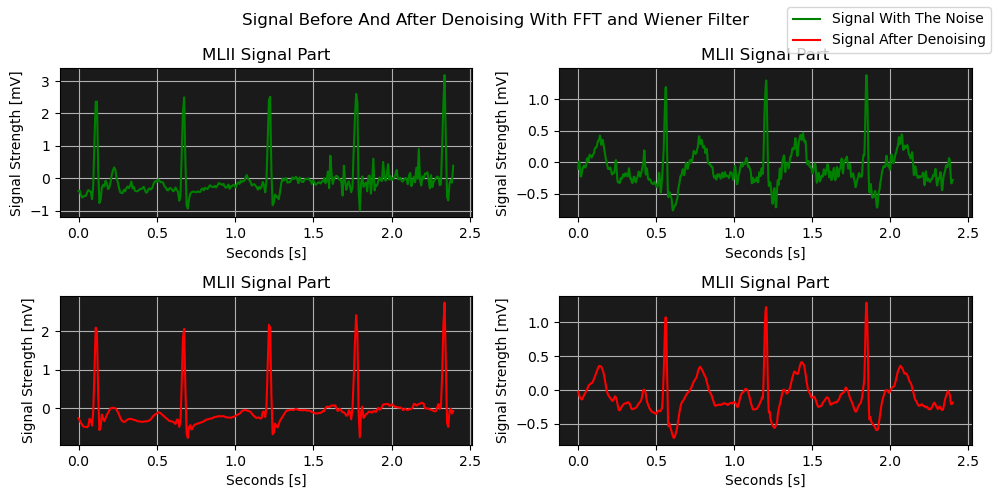

In [198]:
fig, axes = plt.subplots(figsize=(10,5), nrows=2, ncols=2)

plot_signal_data(axes[0, 0], t_normal, signals_tt[20000], plot_kws={"label": 'Signal With The Noise'}, fs=128)
plot_signal_data(axes[1, 0], t_normal, fft_wiener_denoise(signals_tt[20000], 128, time_frame), plot_kws={"label": 'Signal After Denoising', "c": "red"}, fs=128)

plot_signal_data(axes[0, 1], t_anomaly, signals[20000], fs=360)
plot_signal_data(axes[1, 1], t_anomaly, fft_wiener_denoise(signals[20000], 360, time_frame), plot_kws={"c": "red"}, fs=360)


fig.legend()
fig.suptitle('Signal Before And After Denoising With FFT and Wiener Filter')

plt.tight_layout()
plt.show()

fig.savefig("graphs/denoising_wiener_comparison.png")

# Wavelet filter

In [10]:
def mean_absolute_deviation(signal: np.array, axis=None):
    return np.mean(np.absolute(signal - np.mean(signal, axis)), axis)

def wavelet_denoising(x, wavelet='sym4', level=1):
    coeff = pywt.wavedec(x, wavelet, mode="per")
    sigma = (1/0.6745) * mean_absolute_deviation(coeff[-level])
    uthresh = sigma * np.sqrt(2 * np.log(len(x)))
    coeff[1:] = (pywt.threshold(i, value=uthresh, mode='hard') for i in coeff[1:])
    return pywt.waverec(coeff, wavelet, mode='per')

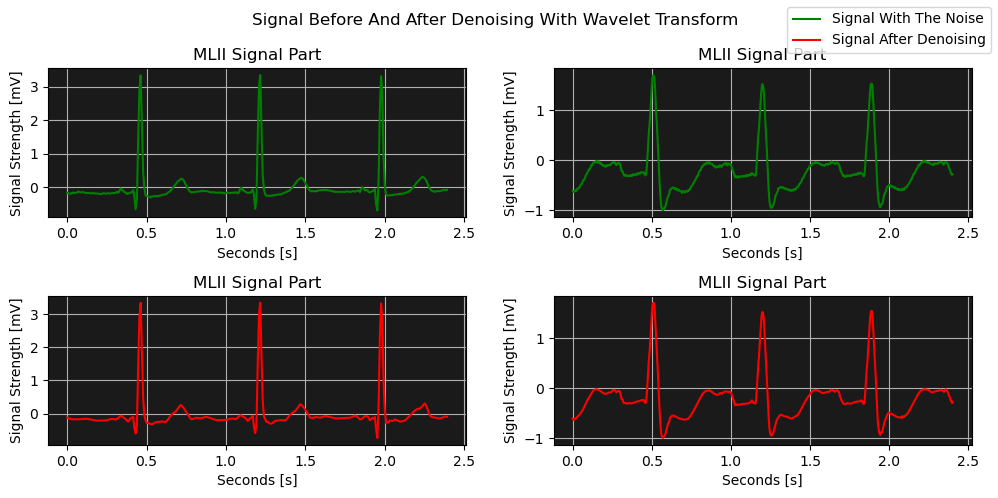

In [11]:
fig, axes = plt.subplots(figsize=(10,5), nrows=2, ncols=2)

plot_signal_data(axes[0, 0], t_normal, signals_tt[20000], plot_kws={"label": 'Signal With The Noise'}, fs=128)
plot_signal_data(axes[1, 0], t_normal, wavelet_denoising(signals_tt[20000]), plot_kws={"label": 'Signal After Denoising', "c": "red"}, fs=128)

plot_signal_data(axes[0, 1], t_anomaly, signals[20000], fs=360)
plot_signal_data(axes[1, 1], t_anomaly, wavelet_denoising(signals[20000]), plot_kws={"c": "red"}, fs=360)


fig.legend()
fig.suptitle('Signal Before And After Denoising With Wavelet Transform')

plt.tight_layout()
plt.show()

In [12]:
def normalize_signal(signal):
    min_val = np.min(signal)
    max_val = np.max(signal)
    return (signal - min_val) / (max_val - min_val)

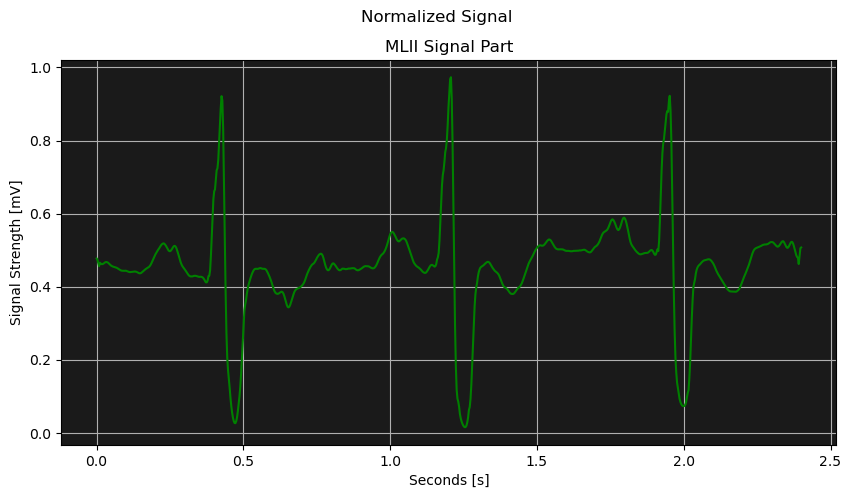

In [202]:
fig, ax = plt.subplots(figsize=(10,5))

plot_signal_data(ax, t_anomaly, fft_wiener_denoise(normalize_signal(signals[993]), fs=360))

fig.suptitle("Normalized Signal")

plt.show()
fig.savefig("graphs/normalized_signal.png")

# Creating a scaled and denoised dataset

In [ ]:
str.isdi

In [114]:
ppp = np.array([np.array([1,2,3]), 
               np.array([1,2,4]),
               np.array([1,2,5]),
               np.array([1,2,6])])

ppp[[1,2]]

array([[1, 2, 4],
       [1, 2, 5]])

In [128]:
set([file[:5] for file in os.listdir(NORMAL_PATH) if file[0].isdigit()])

{'16265',
 '16272',
 '16273',
 '16420',
 '16483',
 '16539',
 '16773',
 '16786',
 '16795',
 '17052',
 '17453',
 '18177',
 '18184',
 '19088',
 '19090',
 '19093',
 '19140',
 '19830'}

In [86]:
ggg = np.array([1,2,3])
hhh = [4,5,6]

np.hstack([ggg, hhh])

array([1, 2, 3, 4, 5, 6])

In [24]:
def load_patients(path: str, id_len: int = 3, fs: int = 360, label: int = 1, seconds: float = 1.2):
    temp_labels = []
    temp_signals = []

    for patient in set([file[:id_len] for file in os.listdir(path) if file[0].isdigit()]): # unique patient ids
        ecg_signal, ecg_annotation, annotation_symbol = load_full_ecg(path, patient)
        
        for smpl, symb in zip(ecg_annotation, annotation_symbol):

            if label and symb not in anomalies:
                continue
                
            temp_signal = ecg_signal[smpl-int(seconds*fs):smpl+int(seconds*fs)]

            desired_shape = 864 if fs == 360 else 306
        
            if temp_signal.shape[0] == desired_shape:
                if desired_shape == 306:
                    temp_signal = resample(temp_signal, 864) # resampling in order to get the same dimension
                temp_signal = normalize_signal(temp_signal)
                temp_signal = fft_wiener_denoise(temp_signal, fs=fs)
                        
                temp_signals.append(temp_signal)
                temp_labels.append(label) # marking anomalied as 1

    return temp_signals, temp_labels

In [26]:
def generate_dataset(seconds: float = 1.2):
    signals = []
    labels = []
    
    # ANOMALY
    t_sig, t_lab = load_patients(ARRYTHMIA_PATH, 3, 360, 1, 1.2)
    anomaly_count = len(t_sig)

    signals += t_sig
    labels += t_lab
    print("anomaly finish")
    
    # NORMAL
    t_sig, t_lab = load_patients(NORMAL_PATH, 5, 128, 0, 1.2)
    random_indices = np.random.choice(np.arange(len(t_lab)), size=18*20000, replace=False)

    t_sig = [t_sig[i] for i in random_indices]
    t_lab = [t_lab[i] for i in random_indices]

    signals += t_sig
    labels += t_lab
    print("normal finish")

    # NORMAL FROM ABNORMAL SET
    w_half = int(seconds * 360)
    
    for patient in set([file[:3] for file in os.listdir(ARRYTHMIA_PATH)]):
        ecg_signal, ecg_annotation, annotation_symbol = load_full_ecg(ARRYTHMIA_PATH, patient)
        annotation_symbol = np.array(annotation_symbol)
        anom = ecg_annotation[annotation_symbol != "N"]

        for idx, smpl in enumerate(ecg_annotation):
            if annotation_symbol[idx] == "N":
                lower_bound = smpl - w_half
                upper_bound = smpl + w_half
                if not any((anom > lower_bound) & (anom < upper_bound)):
                    temp_signal = ecg_signal[smpl-int(seconds*360):smpl+int(seconds*360)]  # fs = 360
                    
                    if temp_signal.shape[0] == 864:
                        temp_signal = normalize_signal(temp_signal)
                        temp_signal = fft_wiener_denoise(temp_signal, fs=360)
                    
                        signals.append(temp_signal)
                        labels.append(0)
        

    train_indices = np.random.choice(np.arange(anomaly_count, len(signals)), size=len(signals) - 3 * anomaly_count, replace=False)
    test_indices = np.setdiff1d(np.arange(len(signals)), train_indices)

    X_train = np.array(signals)[train_indices]
    y_train = np.array(labels)[train_indices]

    X_test = np.array(signals)[test_indices]
    y_test = np.array(labels)[test_indices]

    return X_train, y_train, X_test, y_test

In [28]:
X_train, y_train, X_test, y_test = generate_dataset()

anomaly finish
normal finish


In [32]:
pd.Series(y_train).value_counts()

0    351382
Name: count, dtype: int64

In [34]:
with h5py.File("data/X_train_2.h5", 'w') as f:
    f.create_dataset('X_train', data=X_train, compression='gzip')

with h5py.File("data/X_test_2.h5", 'w') as f:
    f.create_dataset('X_test', data=X_test, compression='gzip')

with h5py.File("data/y_train_2.h5", 'w') as f:
    f.create_dataset('y_train', data=y_train, compression='gzip')

with h5py.File("data/y_test_2.h5", 'w') as f:
    f.create_dataset('y_test', data=y_test, compression='gzip')